# Analytical LQG

In [14]:
import pickle

import numpy as np
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

from src.algorithm.backward_feature_selection import BackwardFeatureSelector
from src.algorithm.info_theory.combo_estimators import NpeetEstimator
from src.algorithm.utils import env_name, episodes_with_len
from src.algorithm.info_theory.it_estimator import ItEstimator
from src.envs.lqgNdim import LQG_nD
from src.wenvs import WrapperEnv

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def resetNormal(env):
    state = np.random.multivariate_normal(np.zeros(4), 20*np.eye(4))
    return env.reset_orig(state=state)

In [4]:
LQG_nD.reset_orig = LQG_nD.reset
LQG_nD.reset = resetNormal

In [5]:
Q = np.diag([0.9, 0.9, 0.1, 0.1])
R = Q.copy()
env = LQG_nD(0.9, n_dim=4, Q=Q, R=R)

In [6]:
policy = env.gaussianPolicy(env.computeOptimalK()*2, Sigma=2)

In [7]:
class NormalEstimator(ItEstimator):
    def flags(self):
        return False, False, False
    def entropy(self, X):
        shape = np.mean(X, axis=0), np.cov(X, rowvar=0)
        rv = multivariate_normal(*shape)
        return rv.entropy()

In [8]:
l_n = [500, 1000, 2000, 5000]
l_k = [20, 30, 40, 50]
l_gamma = [0.5, 0.9, 0.95]

wenv = WrapperEnv(env, continuous_state=True, continuous_actions=True)
discrete = False

np.random.seed(0)
wenv.seed(0)

trajectories = episodes_with_len(wenv, l_n[-1], l_k[-1], policy=None)

In [30]:
min_len = min([len(t) for t in trajectories])
rew_per_traj = np.dstack([t[:min_len] for t in trajectories])[:, -1, :]

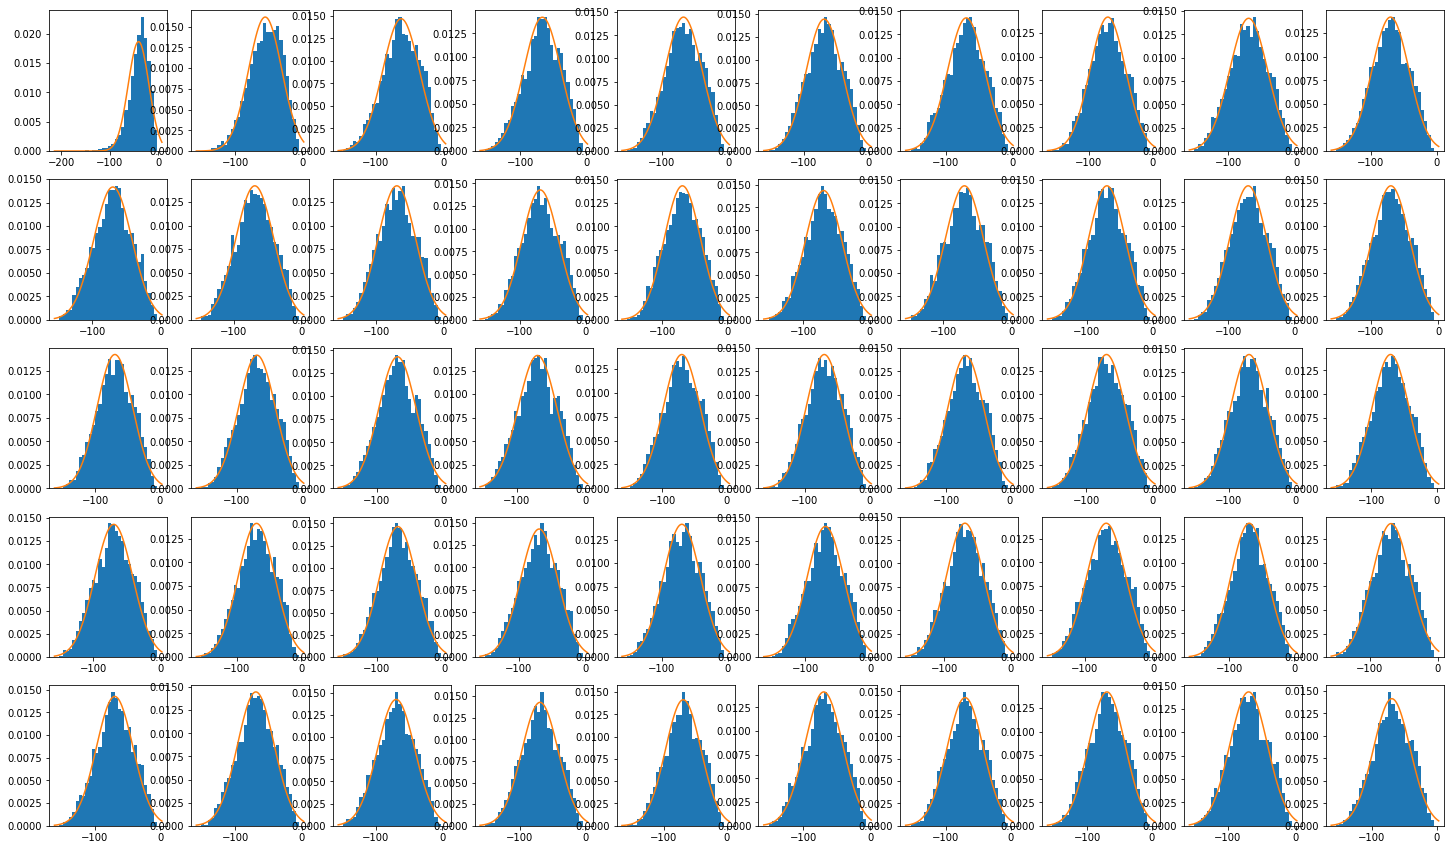

In [58]:
fig, axes = plt.subplots(5, 10, figsize=(25,15))
for ax, row in zip(axes.ravel(), rew_per_traj):
    ax.hist(row, bins=30, density=True)
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm(*norm.fit(row)).pdf(x)
    ax.plot(x, y) 

In [9]:
db = {}
fs = BackwardFeatureSelector(NormalEstimator(), trajectories, nproc=None)
for k in l_k:
    for gamma in l_gamma:
        key = (env_name(env), NormalEstimator.__name__, l_n[-1], k, gamma)
        print('\n', key, flush=True)
        res = [(set(fs.idSet),
                fs.scoreSubset(k, gamma, fs.idSet))]
        res += list(fs.try_all(k, gamma))
        db[key] = res

2019-10-03 12:19:03,281	WARNING resource_spec.py:163 -- Warning: Capping object memory store to 20.0GB. To increase this further, specify `object_store_memory` when calling ray.init() or ray start.
2019-10-03 12:19:03,284	INFO resource_spec.py:205 -- Starting Ray with 166.99 GiB memory available for workers and up to 18.63 GiB for objects. You can adjust these settings with ray.remote(memory=<bytes>, object_store_memory=<bytes>).



 ('LQG_nD', 'NormalEstimator', 5000, 20, 0.5)




 ('LQG_nD', 'NormalEstimator', 5000, 20, 0.9)




 ('LQG_nD', 'NormalEstimator', 5000, 20, 0.95)




 ('LQG_nD', 'NormalEstimator', 5000, 30, 0.5)




 ('LQG_nD', 'NormalEstimator', 5000, 30, 0.9)




 ('LQG_nD', 'NormalEstimator', 5000, 30, 0.95)




 ('LQG_nD', 'NormalEstimator', 5000, 40, 0.5)




 ('LQG_nD', 'NormalEstimator', 5000, 40, 0.9)




 ('LQG_nD', 'NormalEstimator', 5000, 40, 0.95)




 ('LQG_nD', 'NormalEstimator', 5000, 50, 0.5)




 ('LQG_nD', 'NormalEstimator', 5000, 50, 0.9)




 ('LQG_nD', 'NormalEstimator', 5000, 50, 0.95)


In [10]:
db

{('LQG_nD',
  'NormalEstimator',
  5000,
  20,
  0.5): [({0, 1, 2, 3, 4, 5, 6, 7},
   0.0006073037249703148), ({0, 1, 2, 4, 5, 6, 7}, 1.7464642359278866), ({0,
    2,
    4,
    5,
    6,
    7},
   3.1338984869332602), ({0, 2, 4, 5, 7}, 3.917063712244322), ({0, 2, 4, 5},
   5.315385933960682), ({2, 4, 5}, 6.631452304682053), ({2, 5},
   7.992930523872956), ({2}, 9.50252769000497), (set(), 10.62929108826184)],
 ('LQG_nD',
  'NormalEstimator',
  5000,
  20,
  0.9): [({0, 1, 2, 3, 4, 5, 6, 7},
   387.10256705093985), ({0, 1, 2, 4, 5, 6, 7}, 397.41220320347327), ({0,
    2,
    4,
    5,
    6,
    7},
   404.2246359938925), ({0, 2, 4, 5, 7}, 409.1491686452179), ({0, 4, 5, 7},
   413.9429609693736), ({4, 5, 7}, 419.58779275419704), ({4, 7},
   424.69620279394934), ({7}, 429.94840600903575), (set(),
   437.18503586805247)],
 ('LQG_nD',
  'NormalEstimator',
  5000,
  20,
  0.95): [({0, 1, 2, 3, 4, 5, 6, 7},
   2282.8530902302878), ({0, 1, 2, 4, 5, 6, 7},
   2297.9074483149348), ({0, 1, 4, 5

In [11]:
with open("analy-lqg.pkl", 'wb') as fp:
    pickle.dump(db, fp, pickle.HIGHEST_PROTOCOL)

In [13]:
class AnalyticalEstimator():
    def __init__(self, feat_means, feat_covs, traj):
        self.feat_means = feat_meanst_means
        self.feat_covs = feat_covs
        min_len = min([len(t) for t in traj])
        rew_per_traj = np.dstack([t[:min_len] for t in traj])[:, -1, :]
        self.rt_as_norm = []
        for row in rew_per_traj:
            self.rt_as_norm += [norm.fit(row)]

    def _get_feat_shape(X):
        X = list(X)
        x_means = self.feat_means[X]
        x_covs = self.feat_covs[X, X]
        return x_means, x_covs

    def _mi(t, X):
        r_shape = self.rt_as_norm[t]
        x_shapes = self._get_feat_shape(X)
        #no sense without covariance with feats
        return 

    def estimateCMI(self, R, Y, Z, t=0):
        assert R == {-1}
        return self._mi(t, Y.union(Z)) - self._mi(t, Z)

In [ ]:
db = {}
fs = BackwardFeatureSelector(NormalEstimator(), trajectories, nproc=None)
for k in l_k:
    for gamma in l_gamma:
        key = (env_name(env), NormalEstimator.__name__, l_n[-1], k, gamma)
        print('\n', key, flush=True)
        res = [(set(fs.idSet),
                fs.scoreSubset(k, gamma, fs.idSet))]
        res += list(fs.try_all(k, gamma))
        db[key] = res